# Notebook 2.2
This notebook documents the procedure to obtain the performance metrics for the trained models to be summarized in box plot format. 

In [2]:
from tqdm.auto import tqdm 
from tqdm import tqdm 
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
%matplotlib inline
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import ast,gc,pickle
from copy import deepcopy
import os

# Custom packages
import read_config
from util.data_process import read_vars, proc_dataset, miss
from util.models import performance_scores,train_baseline,causal_settings,train_PC1

/Users/fredericktam/anaconda3/envs/AMSsat/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Read configuration file
config_set = read_config.read_config()
# Define Target
if int(config_set['target_lag'])==20:
    target='DELV120'
if int(config_set['target_lag'])==16:
    target='DELV96'
if int(config_set['target_lag'])==12:
    target='DELV72'
if int(config_set['target_lag'])==8:
    target='DELV48'
if int(config_set['target_lag'])==4:
    target='DELV24'
# Define seed and variable names information
seeds = np.arange(0,7,1)
var_names = performance_scores.scores_seeds(seed=0,target=target,lag=int(config_set['target_lag']),exp='shipsold').read_stored()['var_names']

## Score the no feature selection models
Change the "exp" to "shipsnew" if you are scoring the SHIPS+ models. Keep "shipsold" for scoring SHIPS models.


In [8]:
score_nocausal = []
for seed in tqdm(seeds):
    # Calculate performance metrics for 24-h ERA5 SHIPS models
    nocausal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsold').run_score_noFS()
    score_nocausal.append(nocausal_results)
    del nocausal_results
    gc.collect()

# The nocausal_results is a complex dictionary, we just want the r2 here.
r2_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2'] for i in range(len(score_nocausal))]
r2_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2'] for i in range(len(score_nocausal))]
r2_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2'] for i in range(len(score_nocausal))]
# The nocausal_results is a complex dictionary, we just want the PCC here.
pcc_train_noFS = [score_nocausal[i]['scoreboard']['train']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_valid_noFS = [score_nocausal[i]['scoreboard']['valid']['r2_from_pcc'] for i in range(len(score_nocausal))]
pcc_test_noFS = [score_nocausal[i]['scoreboard']['test']['r2_from_pcc'] for i in range(len(score_nocausal))]

  0%|          | 0/7 [00:00<?, ?it/s]/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:132: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:134: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][ke

In [9]:
# Find the cross-validation fold that has the best mean validation score
bestfold_noFS = np.asarray([np.mean(obj) for obj in pcc_valid_noFS]).argmax()
# Find the model having the best validation score within that fold
bestmodel_noFS = [np.argmax(obj) for obj in pcc_valid_noFS][bestfold_noFS]
print(bestfold_noFS,bestmodel_noFS)

6 0


## Score the causal feature selection models

In [10]:
# Score causal feature selection models
score_causal = []
for seed in tqdm(seeds):
    causal_results = performance_scores.scores_seeds(seed=seed,target=target,lag=int(config_set['target_lag']),exp='shipsnew').run_score_causalFS()
    score_causal.append(causal_results)
    del causal_results
    gc.collect()
# Save the R2 and data shape for reference
r2_train_causalFS, r2_valid_causalFS, r2_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    r2_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2']) for j in range(len(score_causal[i]))])
    r2_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2']) for j in range(len(score_causal[i]))])
    r2_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])
# Save the PCC and data shape for reference
pcc_train_causalFS, pcc_valid_causalFS, pcc_test_causalFS, shapez_causalFS = [],[],[],[]
for i in range(len(score_causal)):
    pcc_train_causalFS.append([(score_causal[i][j]['scoreboard']['train']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_valid_causalFS.append([(score_causal[i][j]['scoreboard']['valid']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    pcc_test_causalFS.append([(score_causal[i][j]['scoreboard']['test']['r2_from_pcc']) for j in range(len(score_causal[i]))])
    shapez_causalFS.append([(score_causal[i][j]['X']['test'].shape[1]) for j in range(len(score_causal[i]))])

  0%|          | 0/7 [00:00<?, ?it/s]/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:158: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:159: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][ke

The score_causal is structured (fold,modelnum). The results for individual model score_causal[fold][modelnum] is a dictionary containing:
- the performance metric (scoreboard)
- inputs (X)
- outputs (y)
- trained regression models (regr)
- the subset of variable names used by that model (corrrank).

In [13]:
score_causal[3][14]['corrrank']

['POT', 'PSLV', 'SHL1', 'G200', 'T200', 'SHMD', 'PVOR']

In [11]:
idx = 3
with open(f"./proc/best_mlr_model_fold{idx}.pkl", "wb") as f:
    pickle.dump(score_causal[idx][np.asarray(r2_valid_causalFS[idx]).argmax()]['regr'], f)

with open(f"./proc/best_mlr_dict_fold{idx}.pkl", "wb") as f:
    pickle.dump(score_causal[idx][np.asarray(r2_valid_causalFS[idx]).argmax()], f)

## Score the correlation feature selection models

In [12]:
score_correlation = []
for seed in tqdm(seeds):
    correlation_results = performance_scores.scores_seeds(seed=seed,target=target,
                                                          lag=int(config_set['target_lag']),exp='shipsold').run_score_corrFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    score_correlation.append(correlation_results)
    del correlation_results
    gc.collect()

r2_train_corrFS, r2_valid_corrFS, r2_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_corrFS.append(trains)
    r2_valid_corrFS.append(valids)
    r2_test_corrFS.append(tests)

pcc_train_corrFS, pcc_valid_corrFS, pcc_test_corrFS = [],[],[]
for i in range(len(score_correlation)):
    tempscore = score_correlation[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_corrFS.append(trains)
    pcc_valid_corrFS.append(valids)
    pcc_test_corrFS.append(tests)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:174: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:190: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][ke

## Score the XAI random forest feature selection models

In [13]:
# Define the directory where the pickle files will be stored
import os
save_dir = 'results/4/XAI_shipsold/'

# Ensure the directory exists, if not, create it
os.makedirs(save_dir, exist_ok=True)

score_corr = []
for seed in tqdm(seeds):
    corr_results = performance_scores.scores_seeds(seed=seed, target=target, lag=int(config_set['target_lag']), exp='shipsold').run_score_XAIFS(shapez=np.asarray(miss.flatten(shapez_causalFS)).max())
    
    # Save the result to a pickle file for each seed with the specified path
    save_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(corr_results, f)
    
    score_corr.append(corr_results)
    del corr_results
    gc.collect()


  0%|          | 0/7 [00:00<?, ?it/s]/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:101: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ytrain = np.concatenate([np.asarray(Xnorml['train'][key].dropna()[target][self.lagtime:]) for key in Xnorml['train'].keys()],axis=0)
/Users/fredericktam/sciwork/2025_CausalSHIPS/util/models/performance_scores.py:103: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yvalid = np.concatenate([np.asarray(Xnorml['valid'][ke

In [14]:
save_dir= f"results/{(int(config_set['target_lag']))}/XAI_shipsold/"
# List to store the loaded results
score_corr = []

# Load each pickle file and append to score_corr
for seed in seeds:
    file_path = os.path.join(save_dir, f'xai_results_fold_{seed}.pkl')
    with open(file_path, 'rb') as f:
        corr_results = pickle.load(f)
        score_corr.append(corr_results)

r2_train_XAIFS, r2_valid_XAIFS, r2_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2'])
        valids.append(tempscore[j]['valid']['r2'])
        tests.append(tempscore[j]['test']['r2'])
    r2_train_XAIFS.append(trains)
    r2_valid_XAIFS.append(valids)
    r2_test_XAIFS.append(tests)

pcc_train_XAIFS, pcc_valid_XAIFS, pcc_test_XAIFS = [],[],[]
for i in range(len(score_corr)):
    tempscore = score_corr[i]['scoreboard']
    trains,valids,tests=[],[],[]
    for j in range(len(tempscore)):
        trains.append(tempscore[j]['train']['r2_from_pcc'])
        valids.append(tempscore[j]['valid']['r2_from_pcc'])
        tests.append(tempscore[j]['test']['r2_from_pcc'])
    pcc_train_XAIFS.append(trains)
    pcc_valid_XAIFS.append(valids)
    pcc_test_XAIFS.append(tests)

## Now putting the metrics for all feature selection models together in a dictionary bundle for the bar plots

In [15]:
import pickle

# === Bundle your arrays ===
pccbox_delv24 = {
    'train_noFS': pcc_train_noFS,
    'valid_noFS': pcc_valid_noFS,
    'test_noFS': pcc_test_noFS,

    'train_causalFS': pcc_train_causalFS,
    'valid_causalFS': pcc_valid_causalFS,
    'test_causalFS': pcc_test_causalFS,

    'train_corrFS': pcc_train_corrFS,
    'valid_corrFS': pcc_valid_corrFS,
    'test_corrFS': pcc_test_corrFS,

    'train_XAIFS': pcc_train_XAIFS,
    'valid_XAIFS': pcc_valid_XAIFS,
    'test_XAIFS': pcc_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/pccbox_shipsold_{target}.pkl', 'wb') as f:
    pickle.dump(pccbox_delv24, f)

print(f"✅ Saved pccbox_shipsold_{target}.pkl")

✅ Saved pccbox_shipsold_DELV24.pkl


In [19]:
import pickle

# === Bundle your arrays ===
pccbox_delv24 = {
    'train_noFS': r2_train_noFS,
    'valid_noFS': r2_valid_noFS,
    'test_noFS': r2_test_noFS,

    'train_causalFS': r2_train_causalFS,
    'valid_causalFS': r2_valid_causalFS,
    'test_causalFS': r2_test_causalFS,

    'train_corrFS': r2_train_corrFS,
    'valid_corrFS': r2_valid_corrFS,
    'test_corrFS': r2_test_corrFS,

    'train_XAIFS': r2_train_XAIFS,
    'valid_XAIFS': r2_valid_XAIFS,
    'test_XAIFS': r2_test_XAIFS,
}

# === Save to pickle ===
with open(f'box_plot_pkl/r2box_shipsold_{target}.pkl', 'wb') as f:
    pickle.dump(pccbox_delv24, f)

print(f"✅ Saved r2box_shipsold_{target}.pkl")

✅ Saved r2box_shipsold_DELV24.pkl


In [16]:
import pickle

# === Update this to your file ===
pkl_path = './proc/mlp_models_causal_old_4.pkl'

# === Open and load ===
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)

print(f"Top-level keys in {pkl_path}:")
print(data.keys())

# === Now pick ONE fold to look inside ===
for k in data.keys():
    print(f"Example fold: {k}")
    fold = data[k]
    print("Keys in this fold:", fold.keys())
    
    # If you want to see contents:
    for key in fold.keys():
        print(f"--> {key}:", fold[key])
    
    break  # remove this if you want to loop through ALL folds


Top-level keys in ./proc/mlp_models_causal_old_4.pkl:
dict_keys(['results_fold_0.pkl', 'results_fold_1.pkl', 'results_fold_2.pkl', 'results_fold_3.pkl', 'results_fold_4.pkl', 'results_fold_5.pkl', 'results_fold_6.pkl', 'results_morei_fold_0.pkl', 'results_morei_fold_1.pkl', 'results_morei_fold_2.pkl', 'results_morei_fold_3.pkl', 'results_morei_fold_4.pkl', 'results_morei_fold_5.pkl', 'results_morei_fold_6.pkl'])
Example fold: results_fold_0.pkl
Keys in this fold: dict_keys(['model_state', 'Evaluation Scores', 'train_losses', 'valid_losses'])
--> model_state: OrderedDict([('fc1.weight', tensor([[-0.0352,  0.2133, -0.0774,  ...,  0.0635, -0.0298,  0.1087],
        [-0.1391, -0.0590, -0.0788,  ..., -0.0426, -0.0705, -0.2013],
        [ 0.0662, -0.0730,  0.1794,  ...,  0.1516, -0.1417, -0.1308],
        ...,
        [-0.1598,  0.1191,  0.1079,  ...,  0.2177, -0.1939,  0.1937],
        [-0.1472, -0.1705, -0.1168,  ...,  0.0148, -0.0373,  0.0472],
        [-0.0304,  0.0599, -0.0876,  ...,  0

## Now we would like to put all our numbers into bar plots to see the difference between linear and nonlinear models trained with SHIPS and SHIPS+ predictors

In [16]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# === Use AMS-style serif font ===
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Nimbus Roman', 'Times', 'C059-Roman', 'P052-Roman', 'DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'stix'

# === Setup ===
lead_times = [24, 48, 72, 96, 120]
datasets = ['shipsold', 'shipsplus']

# Okabe-Ito colorblind-friendly palette
colors = {
    'NoFS-SHIPS': "#0072B2",    # Blue
    'NoFS-SHIPS+': "#D55E00",   # Vermillion
    'MLP-SHIPS': "#009E73",     # Bluish Green
    'MLP-SHIPS+': "#E69F00"     # Orange
}

mean_line_color = "#000000"     # Black
median_line_color = "#7C3F00"    # Brown

# === Helpers ===
def flatten_all(folds_list):
    flat_vals = []
    for fold in folds_list:
        if isinstance(fold, (list, np.ndarray)):
            flat_vals.extend(fold)
        else:
            flat_vals.append(fold)
    return np.array(flat_vals)

def collect_mlp_r2(mlp_pkl_path):
    with open(mlp_pkl_path, 'rb') as f:
        folds = pickle.load(f)
    r2_test = []
    for k, fold in folds.items():
        if 'Evaluation Scores' in fold and 'test_r2' in fold['Evaluation Scores']:
            val = fold['Evaluation Scores']['test_r2']
            if isinstance(val, torch.Tensor):
                val = val.item()
            r2_test.append(val)
        else:
            r2_test.append(np.nan)
    return np.array(r2_test)

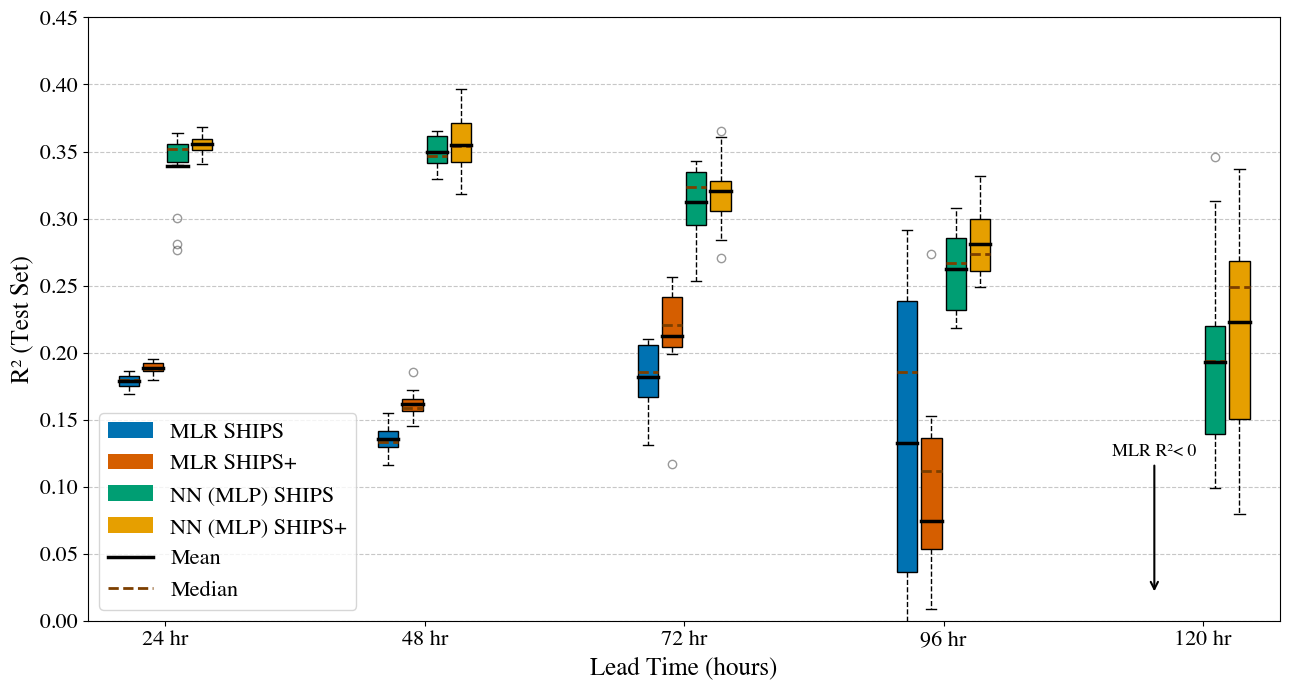

In [20]:
# === Gather box data ===
box_data = []
box_colors = []
group_labels = []

for lt in lead_times:
    # MLR
    for idx, dataset in enumerate(datasets):
        with open(f'box_plot_pkl/r2box_{dataset}_DELV{lt}.pkl', 'rb') as f:
            r2box = pickle.load(f)
        arr = flatten_all(r2box["test_noFS"])
        box_data.append(arr)
        label = f'NoFS-{"SHIPS" if idx==0 else "SHIPS+"}'
        box_colors.append(colors[label])
        group_labels.append(label)

    # MLP
    ships_pkl = f'./proc/mlp_models_causal_oldships_/mlp_models_causal_old_{lt//6}.pkl'
    shipsplus_pkl = f'./proc/mlp_models_causal_plus_/mlp_models_causal_plus_{lt//6}.pkl'
    box_data.append(collect_mlp_r2(ships_pkl))
    box_data.append(collect_mlp_r2(shipsplus_pkl))
    box_colors.append(colors['MLP-SHIPS'])
    box_colors.append(colors['MLP-SHIPS+'])
    group_labels.append('MLP-SHIPS')
    group_labels.append('MLP-SHIPS+')

# === X positions ===
positions = []
start = 1
pair_gap = 0.3
group_gap = 2.0

for _ in lead_times:
    for _ in range(4):  # 2 MLR + 2 MLP
        positions.append(start)
        start += pair_gap
    start += group_gap

# === Plot ===
plt.figure(figsize=(13, 7))
bp = plt.boxplot(
    box_data,
    positions=positions,
    widths=0.25,
    patch_artist=True,
    showmeans=False
)

# Fill colors
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)

# Whiskers & fliers
for whisker in bp["whiskers"]:
    whisker.set(color="black", linestyle="--")
for flier in bp["fliers"]:
    flier.set(marker="o", color="black", alpha=0.4)

# Median lines dashed
for median in bp['medians']:
    median.set(color=median_line_color, linewidth=2.0, linestyle='--')

# Mean lines
for i, data in enumerate(box_data):
    mean_val = np.nanmean(data)
    plt.plot(
        [positions[i] - 0.125, positions[i] + 0.125],
        [mean_val, mean_val],
        color=mean_line_color,
        linewidth=2.5,
        zorder=3
    )

# === X-axis ===
groups_per_leadtime = 4
group_centers = []
for i in range(len(lead_times)):
    group_pos = positions[i*groups_per_leadtime : (i+1)*groups_per_leadtime]
    group_centers.append(np.mean(group_pos))

plt.xticks(group_centers, [f"{lt} hr" for lt in lead_times], fontsize=16)
plt.xlabel("Lead Time (hours)", fontsize=18)
plt.ylabel("R² (Test Set)", fontsize=18)
plt.yticks(fontsize=16)

#plt.title("Test R² vs Lead Time: MLR vs MLP with SHIPS and SHIPS+ Predictors", fontsize=20, fontweight='bold')
plt.grid(axis="y", linestyle="--", alpha=0.7)
# === Add single shared annotation for 120h MLR ===
# === Add single shared annotation for 120h MLR ===
mlr_positions_120 = [positions[16], positions[17]]
x_center = np.mean(mlr_positions_120) - 0.3  # shift left by 0.3 units

plt.annotate(
    "MLR R²< 0",
    xy=(x_center, 0.02),     # arrow tip
    xytext=(x_center, 0.12), # label position
    ha="center", va="bottom",
    fontsize=13,
    arrowprops=dict(
        arrowstyle="->",
        color="black",
        lw=1.5
    )
)
# === Legend ===
handles = [
    mpatches.Patch(facecolor=colors['NoFS-SHIPS'], label='MLR SHIPS'),
    mpatches.Patch(facecolor=colors['NoFS-SHIPS+'], label='MLR SHIPS+'),
    mpatches.Patch(facecolor=colors['MLP-SHIPS'], label='NN (MLP) SHIPS'),
    mpatches.Patch(facecolor=colors['MLP-SHIPS+'], label='NN (MLP) SHIPS+'),
    mlines.Line2D([], [], color=mean_line_color, linewidth=2.5, label='Mean'),
    mlines.Line2D([], [], color=median_line_color, linewidth=2.0, linestyle='--', label='Median')
]
plt.legend(
    handles=handles,
    loc="lower left",
    bbox_to_anchor=(0, 0),
    fontsize=16
)

plt.ylim(0, 0.45)
plt.tight_layout()
plt.savefig('./figures/combined_MLR_vs_MLP_SHIPS_vs_SHIPSplus_R2_LeadTime_ColorblindFriendly.png', dpi=300)
plt.show()



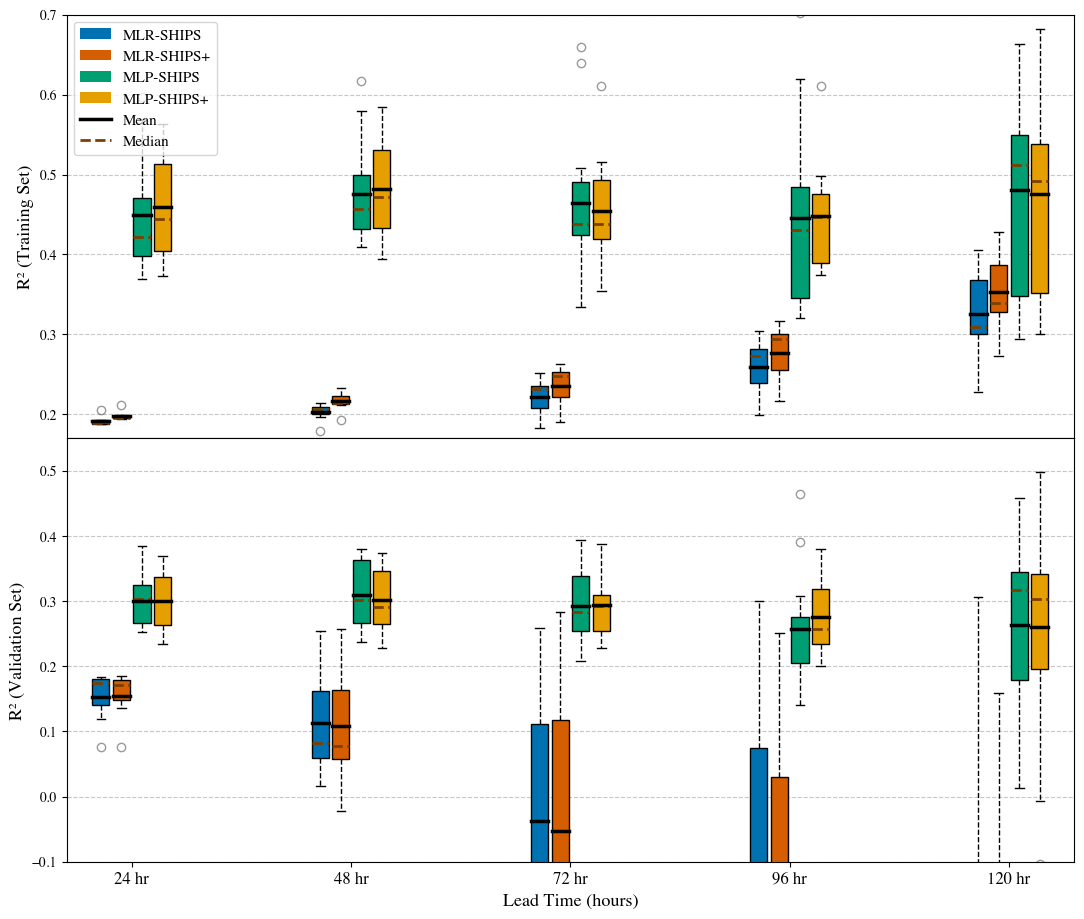

In [19]:
# === Collect all box data ===
box_data_train, box_data_val = [], []
box_colors = []
group_labels = []

for lt in lead_times:
    # MLR
    for idx, dataset in enumerate(datasets):
        with open(f'box_plot_pkl/r2box_{dataset}_DELV{lt}.pkl', 'rb') as f:
            r2box = pickle.load(f)
        tr = flatten_all(r2box["train_noFS"])
        va = flatten_all(r2box["valid_noFS"])
        box_data_train.append(tr)
        box_data_val.append(va)
        label = f'NoFS-{"SHIPS" if idx==0 else "SHIPS+"}'
        box_colors.append(colors[label])
        group_labels.append(label)

    # MLP
    ships_pkl = f'./proc/mlp_models_causal_oldships_/mlp_models_causal_old_{lt//6}.pkl'
    shipsplus_pkl = f'./proc/mlp_models_causal_plus_/mlp_models_causal_plus_{lt//6}.pkl'
    tr1, va1 = collect_mlp_r2_split(ships_pkl)
    tr2, va2 = collect_mlp_r2_split(shipsplus_pkl)
    box_data_train.extend([tr1, tr2])
    box_data_val.extend([va1, va2])
    box_colors.extend([colors['MLP-SHIPS'], colors['MLP-SHIPS+']])
    group_labels.extend(['MLP-SHIPS', 'MLP-SHIPS+'])

# === Positioning ===
positions = []
start = 1
pair_gap = 0.3
group_gap = 2.0
for _ in lead_times:
    for _ in range(4):
        positions.append(start)
        start += pair_gap
    start += group_gap

# === Plotting Panels ===
fig, axes = plt.subplots(2, 1, figsize=(13, 11), sharex=True)

for ax, box_data, split_label in zip(axes, [box_data_train, box_data_val], ['Training', 'Validation']):
    bp = ax.boxplot(
        box_data,
        positions=positions,
        widths=0.25,
        patch_artist=True,
        showmeans=False
    )
    for patch, color in zip(bp["boxes"], box_colors):
        patch.set_facecolor(color)
    for whisker in bp["whiskers"]:
        whisker.set(color="black", linestyle="--")
    for flier in bp["fliers"]:
        flier.set(marker="o", color="black", alpha=0.4)
    for median in bp['medians']:
        median.set(color=median_line_color, linewidth=2.0, linestyle='--')
    for i, data in enumerate(box_data):
        mean_val = np.nanmean(data)
        ax.plot(
            [positions[i] - 0.125, positions[i] + 0.125],
            [mean_val, mean_val],
            color=mean_line_color,
            linewidth=2.5,
            zorder=3
        )
    ax.set_ylabel(f"R² ({split_label} Set)", fontsize=13)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    if split_label == "Training":
        ax.set_ylim(0.17, 0.7)
    elif split_label == "Validation":
        ax.set_ylim(-0.1, 0.55)

# === X-axis labels ===
groups_per_leadtime = 4
group_centers = []
for i in range(len(lead_times)):
    group_pos = positions[i*groups_per_leadtime : (i+1)*groups_per_leadtime]
    group_centers.append(np.mean(group_pos))

axes[-1].set_xticks(group_centers)
axes[-1].set_xticklabels([f"{lt} hr" for lt in lead_times], fontsize=12)
axes[-1].set_xlabel("Lead Time (hours)", fontsize=13)

# === Legend ===
handles = [
    mpatches.Patch(facecolor=colors['NoFS-SHIPS'], label='MLR-SHIPS'),
    mpatches.Patch(facecolor=colors['NoFS-SHIPS+'], label='MLR-SHIPS+'),
    mpatches.Patch(facecolor=colors['MLP-SHIPS'], label='MLP-SHIPS'),
    mpatches.Patch(facecolor=colors['MLP-SHIPS+'], label='MLP-SHIPS+'),
    mlines.Line2D([], [], color=mean_line_color, linewidth=2.5, label='Mean'),
    mlines.Line2D([], [], color=median_line_color, linewidth=2.0, linestyle='--', label='Median')
]
axes[0].legend(handles=handles, loc="upper left", fontsize=11)

plt.subplots_adjust(hspace=0.0)
plt.savefig('./figures/TrainVal_MLR_vs_MLP_SHIPS_vs_SHIPSplus_R2_LeadTime_ColorblindFriendly.png', dpi=300)
plt.show()


In [15]:
import pickle
import torch

def load_fold_scores(pkl_path):
    """Load valid & test R2 for all folds (excluding 'morei')"""
    with open(pkl_path, 'rb') as f:
        folds = pickle.load(f)

    scores = {}
    for k in folds:
        if 'morei' in k:
            continue
        fold = folds[k]
        eval_scores = fold.get('Evaluation Scores', {})
        valid_r2 = eval_scores.get('valid_r2', float('-inf'))
        test_r2 = eval_scores.get('test_r2', float('-inf'))
        if isinstance(valid_r2, torch.Tensor):
            valid_r2 = valid_r2.item()
        if isinstance(test_r2, torch.Tensor):
            test_r2 = test_r2.item()
        scores[k] = {
            'valid_r2': valid_r2,
            'test_r2': test_r2
        }
    return scores

# === FILE PATHS ===
ships_pkl = f'./proc/mlp_models_causal_oldships_/mlp_models_causal_old_4.pkl'
shipsplus_pkl = f'./proc/mlp_models_causal_plus_/mlp_models_causal_plus_4.pkl'

# === LOAD ===
ships_scores = load_fold_scores(ships_pkl)
shipsplus_scores = load_fold_scores(shipsplus_pkl)

# === PRINT COMPARISON ===
print(f"{'Fold':<20} | {'SHIPS Valid':>10} | {'SHIPS Test':>10} | {'SHIPS+ Valid':>10} | {'SHIPS+ Test':>10} | {'ΔTestR²':>8}")
print("-" * 80)

for fold_name in ships_scores:
    if fold_name not in shipsplus_scores:
        continue

    s_valid = ships_scores[fold_name]['valid_r2']
    s_test  = ships_scores[fold_name]['test_r2']
    sp_valid = shipsplus_scores[fold_name]['valid_r2']
    sp_test  = shipsplus_scores[fold_name]['test_r2']
    diff = sp_test - s_test

    print(f"{fold_name:<20} | {s_valid:>10.3f} | {s_test:>10.3f} | {sp_valid:>10.3f} | {sp_test:>10.3f} | {diff:>+8.3f}")

print("\n✅ Done. Check if SHIPS+ consistently outperforms SHIPS across folds!")


Fold                 | SHIPS Valid | SHIPS Test | SHIPS+ Valid | SHIPS+ Test |  ΔTestR²
--------------------------------------------------------------------------------
results_fold_0.pkl   |      0.304 |      0.352 |      0.312 |      0.351 |   -0.001
results_fold_1.pkl   |      0.265 |      0.356 |      0.274 |      0.356 |   -0.000
results_fold_2.pkl   |      0.330 |      0.352 |      0.345 |      0.367 |   +0.015
results_fold_3.pkl   |      0.373 |      0.281 |      0.370 |      0.357 |   +0.076
results_fold_4.pkl   |      0.257 |      0.353 |      0.261 |      0.364 |   +0.011
results_fold_5.pkl   |      0.307 |      0.352 |      0.299 |      0.355 |   +0.003
results_fold_6.pkl   |      0.252 |      0.364 |      0.233 |      0.360 |   -0.004

✅ Done. Check if SHIPS+ consistently outperforms SHIPS across folds!
